# Модель прогнозирования спроса
Краткое описание:
<br>Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День.

Задача:
<br>Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных
признаков.

Метрика качества:
<br>`WAPE`:
<br>`def wape(y_true: np.array, y_pred: np.array):`
    <br>`return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))`

### Описание данных
1) sales_df_train.csv –данные по продажам за скользящий год для обучения.
    * Столбцы:
        - st_id – захэшированное id магазина;
        - pr_sku_id – захэшированное id товара;
        - date – дата;
        - pr_sales_type_id – флаг наличия промо;
        - pr_sales_in_units – число проданных товаров всего (промо и без); **описание изменено после уточнения у бизнеса**
        - pr_promo_sales_in_units – число проданных товаров с признаком промо;
        - pr_sales_in_rub – продажи в РУБ всего (промо и без); **описание изменено после уточнения у бизнеса**
        - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
2) pr_df.csv – данные по товарной иерархии.
<br>От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - Столбцы:
        - pr_group_id – захэшированная группа товара;
        - pr_cat_id – захэшированная категория товара;
        - pr_subcat_id – захэшированная подкатегория товара;
        - pr_sku_id – захэшированное id товара;
        - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
3) pr_st.csv – данные по магазинам.
    - Столбцы:
        - st_id – захэшированное id магазина;
        - st_city_id – захэшированное id города;
        - st_division_code – захэшированное id дивизиона;
        - st_type_format_id – id формата магазина;
        - st_type_loc_id – id тип локации/окружения магазина;
        - st_type_size_id – id типа размера магазина;
        - st_is_active – флаг активного магазина на данный момент.

## Загрузка библиотек

In [1]:
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
from phik.report import plot_correlation_matrix
#from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler
#from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

## Знакомство с данными

Пример файла с результатом прогноза

In [2]:
# sales_submission_ex = pd.read_csv('sp_sales_task/sales_submission.csv')
# sales_submission_ex.head()

In [3]:
pr_df = pd.read_csv('sp_sales_task/pr_df.csv')
pr_st = pd.read_csv('sp_sales_task/st_df.csv')
sales_df = pd.read_csv('sp_sales_task/sales_df_train.csv')

In [4]:
display(pr_df.sample())
pr_df.info()
display(pr_st.sample())
pr_st.info()
display(sales_df.sample())
sales_df.info()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
1772,ee6958ee94a398e249bab04f28660b3d,c74d97b01eae257e44aa9d5bade97baf,7a6a74cbe87bc60030a4bd041dd47b78,ad70a449a504a145c44dbd5228b16c34,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
730557,42a0e188f5033bc65bf8d78622277c4e,54cc81ad9eadc5ccde13e001ddfa3eb1,2022-10-22,1,7.0,7.0,1880.0,1880.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


## Предобработка данных

#### Объединение датафреймов

In [5]:
common_df = sales_df.merge(pr_st, on='st_id', how='left').merge(pr_df, on='pr_sku_id', how='left')
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
782774,16a5cdae362b8d27a1d8f8c7b78b4330,b70e1c1b2c51536fc4744389223a5e9a,2022-09-29,0,4.0,0.0,599.0,0.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,0f3abfd67959c079e7b3759440e7415c,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
 8   st_city_id               883015 non-null  object 
 9   st_division_code         883015 non-null  object 
 10  st_type_format_id        883015 non-null  int64  
 11  st_type_loc_id           883015 non-null  int64  
 12  st_type_size_id          883015 non-null  int64  
 13  st_is_active             883015 non-null  int64  
 14  pr_g

#### Проверка нулевых значений в количестве

In [6]:
sales_units_zero = common_df[common_df['pr_sales_in_units'] == 0]
print(
    'нулевые продажи в шт и руб:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)
print(
    'нулевые продажи в шт, но не нулевые в рублях:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)
sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0].head()

нулевые продажи в шт и руб: 454 
их доля в данных: 0.05 %
нулевые продажи в шт, но не нулевые в рублях: 66089 
их доля в данных: 7.48 %


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1
6,f7e6c85504ce6e82442c770f7c8606f0,b75c7cbf7accdaea8a1a14781bb29870,2023-02-15,0,0.0,0.0,171.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,1
28,f7e6c85504ce6e82442c770f7c8606f0,88d7313785c97631bf3df61e70636491,2022-11-30,0,0.0,0.0,79.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,567115097ac405a46a84ef641c2d7069,1
32,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2023-02-26,0,0.0,0.0,83.0,0.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,1


**Вывод:** 
- в данных имеются записи, которые можно удалить (их доля 0.05%): нулевые значения в количестве проданных товаров и их стоимости
- записи, по которым требуется уточнение в бизнесе (их доля 7.48%): нулевые значения в количестве проданных товаров и ненулевые в их стоимости.

#### Удаление данных с нулями в количестве

In [7]:
common_df = common_df.loc[common_df['pr_sales_in_units'] != 0]
common_df.info()
common_df.sample()

<class 'pandas.core.frame.DataFrame'>
Index: 816472 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    816472 non-null  object 
 1   pr_sku_id                816472 non-null  object 
 2   date                     816472 non-null  object 
 3   pr_sales_type_id         816472 non-null  int64  
 4   pr_sales_in_units        816472 non-null  float64
 5   pr_promo_sales_in_units  816472 non-null  float64
 6   pr_sales_in_rub          816472 non-null  float64
 7   pr_promo_sales_in_rub    816472 non-null  float64
 8   st_city_id               816472 non-null  object 
 9   st_division_code         816472 non-null  object 
 10  st_type_format_id        816472 non-null  int64  
 11  st_type_loc_id           816472 non-null  int64  
 12  st_type_size_id          816472 non-null  int64  
 13  st_is_active             816472 non-null  int64  
 14  pr_group_

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
777224,16a5cdae362b8d27a1d8f8c7b78b4330,eb341a778d385ad6ebe16e90efb48c08,2022-09-26,1,4.0,4.0,823.0,823.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,1


#### Количество активных магазинов

In [8]:
print('количество магазинов без маркера активности:', 
      pr_st[pr_st['st_is_active'] == 0]['st_id'].count(), 
      '\nих доля в общем количестве магазинов:', 
      round(pr_st[pr_st['st_is_active'] == 0]['st_id'].count() / pr_st['st_id'].count(), 2)
     )

количество магазинов без маркера активности: 2 
их доля в общем количестве магазинов: 0.17


#### Количество данных по неактивным магазинам

In [9]:
unactive_store_sales = common_df[common_df['st_is_active'] == 0]
print(
    'количество записей по неактивным магазинам:', 
    unactive_store_sales['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(unactive_store_sales['pr_sales_in_rub'].count() / common_df['pr_sales_in_rub'].count() * 100, 2), '%'
)

количество записей по неактивным магазинам: 728 
их доля в данных: 0.09 %


**Вывод:** в данных найдены магазины без маркера активности. Возможно, их можно удалить, требуется уточнение у бизнеса.

#### Удаление данных по неактивным магазинам

In [10]:
common_df = common_df.loc[~common_df['st_id'].isin(list(pr_st[pr_st['st_is_active'] == 0]['st_id']))]
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
138358,c81e728d9d4c2f636f067f89cc14862c,eb341a778d385ad6ebe16e90efb48c08,2022-08-08,0,12.0,0.0,3464.0,0.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,1


<class 'pandas.core.frame.DataFrame'>
Index: 815744 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    815744 non-null  object 
 1   pr_sku_id                815744 non-null  object 
 2   date                     815744 non-null  object 
 3   pr_sales_type_id         815744 non-null  int64  
 4   pr_sales_in_units        815744 non-null  float64
 5   pr_promo_sales_in_units  815744 non-null  float64
 6   pr_sales_in_rub          815744 non-null  float64
 7   pr_promo_sales_in_rub    815744 non-null  float64
 8   st_city_id               815744 non-null  object 
 9   st_division_code         815744 non-null  object 
 10  st_type_format_id        815744 non-null  int64  
 11  st_type_loc_id           815744 non-null  int64  
 12  st_type_size_id          815744 non-null  int64  
 13  st_is_active             815744 non-null  int64  
 14  pr_group_

#### Изменение формата в поле с датами

In [11]:
common_df['date'] = pd.to_datetime(common_df['date'])
display(common_df.sample())
common_df.info()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
400699,f7e6c85504ce6e82442c770f7c8606f0,f5a455e5fea834c85429331d934c40fa,2023-06-14,0,5.0,0.0,1107.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,38cc804f2e8d4b18785b84c68517eadf,1


<class 'pandas.core.frame.DataFrame'>
Index: 815744 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815744 non-null  object        
 1   pr_sku_id                815744 non-null  object        
 2   date                     815744 non-null  datetime64[ns]
 3   pr_sales_type_id         815744 non-null  int64         
 4   pr_sales_in_units        815744 non-null  float64       
 5   pr_promo_sales_in_units  815744 non-null  float64       
 6   pr_sales_in_rub          815744 non-null  float64       
 7   pr_promo_sales_in_rub    815744 non-null  float64       
 8   st_city_id               815744 non-null  object        
 9   st_division_code         815744 non-null  object        
 10  st_type_format_id        815744 non-null  int64         
 11  st_type_loc_id           815744 non-null  int64         
 12  st_type_size_id      

#### Сортировка в порядке возрастания

In [12]:
common_df = common_df.sort_values(by='date', ignore_index=True)

#### Анализ целевого признака

Количество записей со значением целевого признака меньше нуля

In [13]:
print(
    'количество записей возвратов:', 
    common_df[common_df['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(), 
    '\nих доля в данных:', 
    round(common_df[common_df['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / common_df['pr_sales_in_units'].count() * 100, 2), '%'
)

количество записей возвратов: 71 
их доля в данных: 0.01 %


Удаление записей возвратов

In [14]:
common_df = common_df.loc[common_df['pr_sales_in_units'] > 0]
common_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815673 entries, 0 to 815743
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815673 non-null  object        
 1   pr_sku_id                815673 non-null  object        
 2   date                     815673 non-null  datetime64[ns]
 3   pr_sales_type_id         815673 non-null  int64         
 4   pr_sales_in_units        815673 non-null  float64       
 5   pr_promo_sales_in_units  815673 non-null  float64       
 6   pr_sales_in_rub          815673 non-null  float64       
 7   pr_promo_sales_in_rub    815673 non-null  float64       
 8   st_city_id               815673 non-null  object        
 9   st_division_code         815673 non-null  object        
 10  st_type_format_id        815673 non-null  int64         
 11  st_type_loc_id           815673 non-null  int64         
 12  st_type_size_id      

In [15]:
common_df['pr_sales_in_units'].describe()

count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

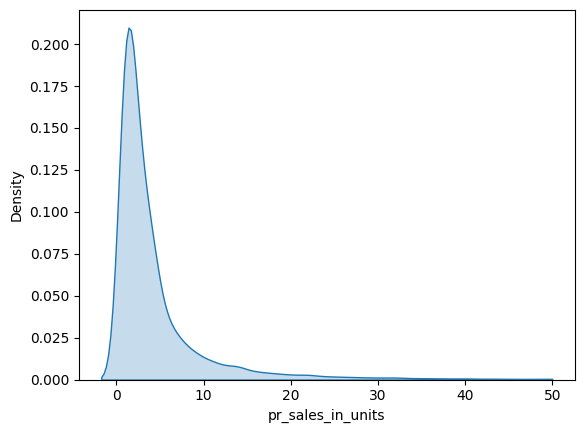

In [16]:
sns.kdeplot(common_df, x='pr_sales_in_units', clip=(-10, 50), fill=True);

**Вывод:** среднее значение больше медианного, наблюдается правосторонняя асимметрия.

#### Добавление календаря РФ

In [17]:
calendar = pd.read_csv('holidays_covid_calendar.csv')
calendar.info()
calendar.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


,year,day,weekday,date,calday,holiday,covid
823,2017,3,1,03.04.2017,20170403,0,0


In [18]:
holidays = calendar[['date', 'holiday']]
holidays['date'] = pd.to_datetime(holidays['date'], format='%d.%m.%Y')

In [19]:
common_df = common_df.merge(holidays, on='date', how='left')
common_df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,holiday
0,c81e728d9d4c2f636f067f89cc14862c,3479dfb41694951fdddeccbe67f59050,2022-08-01,0,2.0,0.0,362.0,0.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,d5bfeecaaa47887a4b92d17fa55c2e18,2022-08-01,1,2.0,2.0,14.0,14.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,0
2,42a0e188f5033bc65bf8d78622277c4e,17667b08596154dc5e9417f410cbced3,2022-08-01,0,1.0,0.0,420.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,0
3,f7e6c85504ce6e82442c770f7c8606f0,064e3a5648fb4a7f911155bd81f87fd2,2022-08-01,0,2.0,0.0,370.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,4aef9bef9b3460130ca6cc0da3eba88a,2022-08-01,0,5.0,0.0,74.0,0.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,0


#### Тепловая диаграмма для выявления корреляции между категориальными признаками

In [21]:
categ_cols = [
    'st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code', 
    'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_is_active', 
    'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id', 'holiday'
    ]
phik_overview = common_df[categ_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_type_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_is_active', 'pr_uom_id', 'holiday']


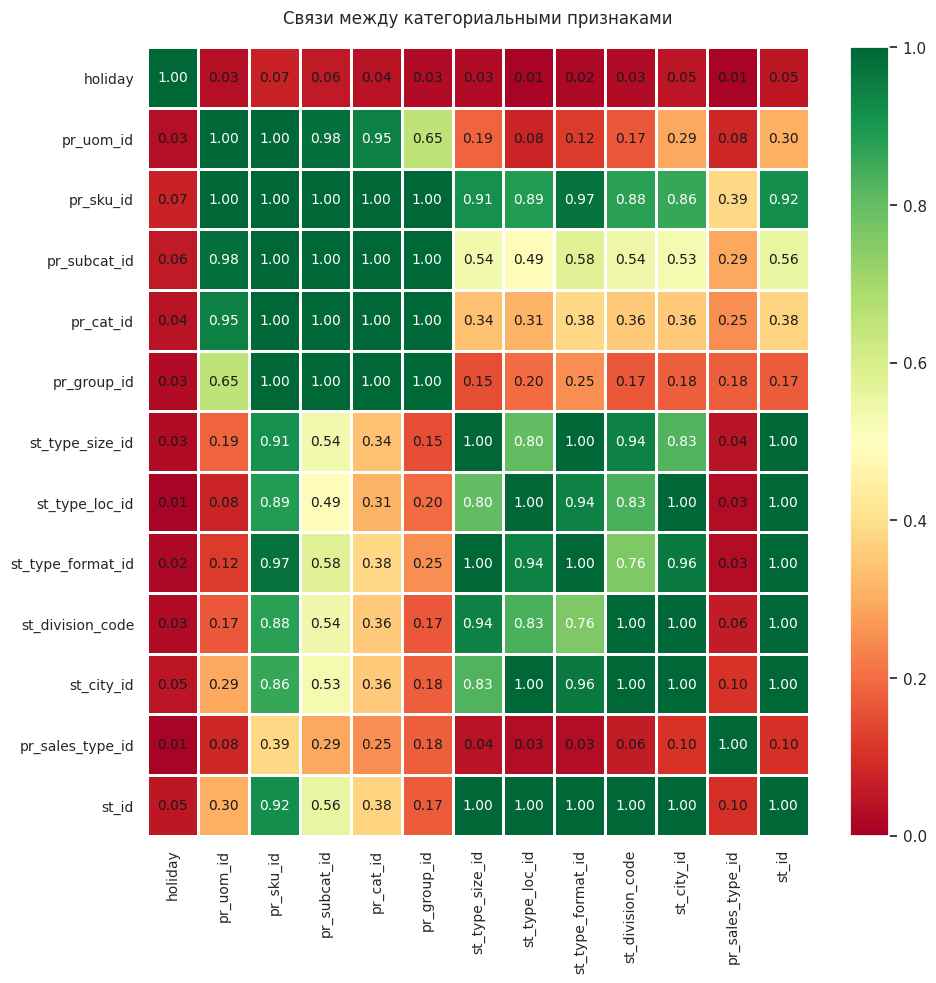

In [22]:
sns.set()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(10, 10))

plt.title('Связи между категориальными признаками', fontsize=12, y=1.02)
plt.tight_layout()

Наблюдается сильная зависимость между категориальными признаками, что вполне логично. <br>Удаление зависимых признаков.

In [23]:
common_df = common_df.drop(
    ['pr_uom_id', 'pr_subcat_id', 'pr_cat_id', 
     'pr_group_id', 'st_type_size_id', 'st_type_loc_id', 'st_type_format_id', 
     'st_division_code', 'st_city_id', 'st_id', 'st_is_active'], axis=1
)

#### Связи между количественными признаками

In [27]:
quant_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
phik_overview_q = common_df[quant_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']


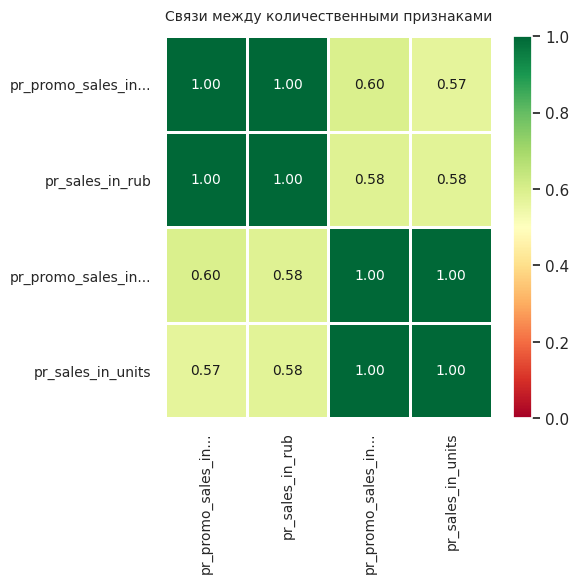

In [30]:
sns.set()
plot_correlation_matrix(phik_overview_q.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(6, 6))

plt.title('Связи между количественными признаками', fontsize=10, y=1.02)
plt.tight_layout()

Удаление взаимнозависимых признаков

In [ ]:
common_df = common_df.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

### Выводы
- Данные предоставлены за период с `01.08.2022` по `18.07.2023`
- Удалены записи (около 7.5% датасета):
    - с нулевыми значениями в количестве проданных товаров и их стоимости,
    - с нулевыми значениями в количестве проданных товаров и ненулевыми в их стоимости (действие согласовано с бизнесом)
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом):
    - им соответствует 729 записей, что составляет 0.08% датасета
- Удалены признаки, имеющие высокую корреляцию

## Чек-лист
1. Файл в зафиксированном формате с результатом прогноза спроса (sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    
    a. Описание обученной модели прогноза спроса
    
        i. Признаки
        ii. интерпретация (shapley values),
        iii. кросс-валидация
        iv. алгоритмы
    
    b. Описание вашего алгоритма оптимизации:
    
        i. методология расчетов
        ii. скорость оптимизации